In [1]:
from modules.cosmology import cosmo_fn
from astropy import units as u
from astropy.coordinates import SkyCoord
from modules.data_preprocess import preprocess_planck_data as ppd
from simulate import cluster_templates as cltemp
from flat_sky_codes import flat_sky_analysis as fsa
from settings import mmf_settings as mmfset
from filters import modular_multi_matched_filter as mmf
from masking import gen_masks as gm
from flat_sky_codes import tangent_plane_analysis as tpa
from modules.simulate.spatial_template import sim_cluster as sc
from modules.settings import constants as cnst
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
mmfset.init()
tmplt=cltemp.cluster_spectro_spatial_templates(T_min=0.,T_max=1.,T_step=1.,theta500_min=2.,theta500_max=4.,theta_step=1.)
tmplt.setup_templates()
emask=gm.return_edge_apodized_mask()
#op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

In [3]:
dtype=["T500","T500_err","z","Mg500","Mg500_err","M500","M500_err","RA","DEC","R500","YSZ_500","YSZ_500_err","YX_500","YX_500_err"]
cat=loadtxt("../data/datain/table4_A_and_A_536_A11_2011.txt")
xsz_cat={}
for idx,d in enumerate(dtype):
    xsz_cat[d]=cat[:,idx]
    
# Estimate the galactic latitude and longitude from RA and DEC
RA=xsz_cat["RA"] ; DEC=xsz_cat["DEC"]
c = SkyCoord(RA, DEC, frame='icrs', unit='deg')
xsz_cat["GLON"]=c.galactic.l.degree
xsz_cat["GLAT"]=c.galactic.b.degree

# Get the angular size for clusters
xsz_cat["theta500"]=(xsz_cat["R500"]/(cosmo_fn.dA(xsz_cat["z"])*1000))*180.*60./np.pi

# Normalizing the X-ray Compton y parameter
norm=(cnst.thomson_cc/cnst.e_rme)*(1./(cnst.mu_e*cnst.m_proton))
xsz_cat["YX_500"]=xsz_cat["YX_500"]*norm
xsz_cat["YX_500_err"]=xsz_cat["YX_500_err"]*norm

In [15]:
cidx=2
glon=xsz_cat["GLON"][cidx]
glat=xsz_cat["GLAT"][cidx]
R500=xsz_cat["R500"][cidx]
T500=xsz_cat["T500"][cidx]
theta500=xsz_cat["theta500"][cidx]/1.177
redshift=xsz_cat["z"][cidx]
data,ps_mask,ext_ps_mask=ppd.return_tangent_planes(glon,glat)
projop=tpa.tangent_plane_setup(mmfset.nside,mmfset.xsize,glat,glon,rescale=1.)

In [16]:
template=tmplt.gen_template(thetac=theta500)
template_ft=fsa.map2alm(np.fft.fftshift(template),mmfset.reso)

temp=tmplt.sz_op.bp_fn_sz_2d_T(0,mmfset.channels)[:,0]
szspec={}
for i,ch in enumerate(mmfset.channels):
    szspec[ch]=temp[i]
    
temp=tmplt.sz_op.bp_fn_sz_2d_T(T500,mmfset.channels)[:,0]
szspecT={}
for i,ch in enumerate(mmfset.channels):
    szspecT[ch]=temp[i]

In [19]:
print xsz_cat["YSZ_500"][cidx],xsz_cat["YSZ_500_err"][cidx]
print xsz_cat["YX_500"][cidx]*1e4,xsz_cat["YX_500_err"][cidx]*1e4
print ""

#op.get_data_ft(data*ps_mask*emask,smwin=5)
op.get_data_ft(data*emask,smwin=2)

fdata,err=op.evaluate_mmf(template_ft,szspec)
ix,iy=projop.ang2ij(glon,glat)
yc=fdata[ix,iy]
cluster=sc.gen_field_cluster_template(ix,iy,theta500,npix=mmfset.npix,pixel_size=mmfset.reso,y0=yc,cutoff=1.)
Y500=np.sum(cluster)*mmfset.reso*mmfset.reso
Y500_err=err*np.sum(cluster/yc)*mmfset.reso*mmfset.reso
print Y500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)*1e4,Y500_err*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)*1e4
print " "#Y500/Y500_err


fdata,err=op.evaluate_mmf(template_ft,szspecT)
ix,iy=projop.ang2ij(glon,glat)
yc=fdata[ix,iy]
cluster=sc.gen_field_cluster_template(ix,iy,theta500,npix=mmfset.npix,pixel_size=mmfset.reso,y0=yc,cutoff=1.)
Y500=np.sum(cluster)*mmfset.reso*mmfset.reso
Y500_err=err*np.sum(cluster/yc)*mmfset.reso*mmfset.reso
print Y500*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)*1e4,Y500_err*((cosmo_fn.dA(redshift)*(np.pi/180./60.))**2.)*1e4
#print Y500/Y500_err

1.4 0.17
3.45775048043 0.135598058056

0.68497141923 0.11761944247
 
0.738033522742 0.127501112626


<IPython.core.display.Javascript object>


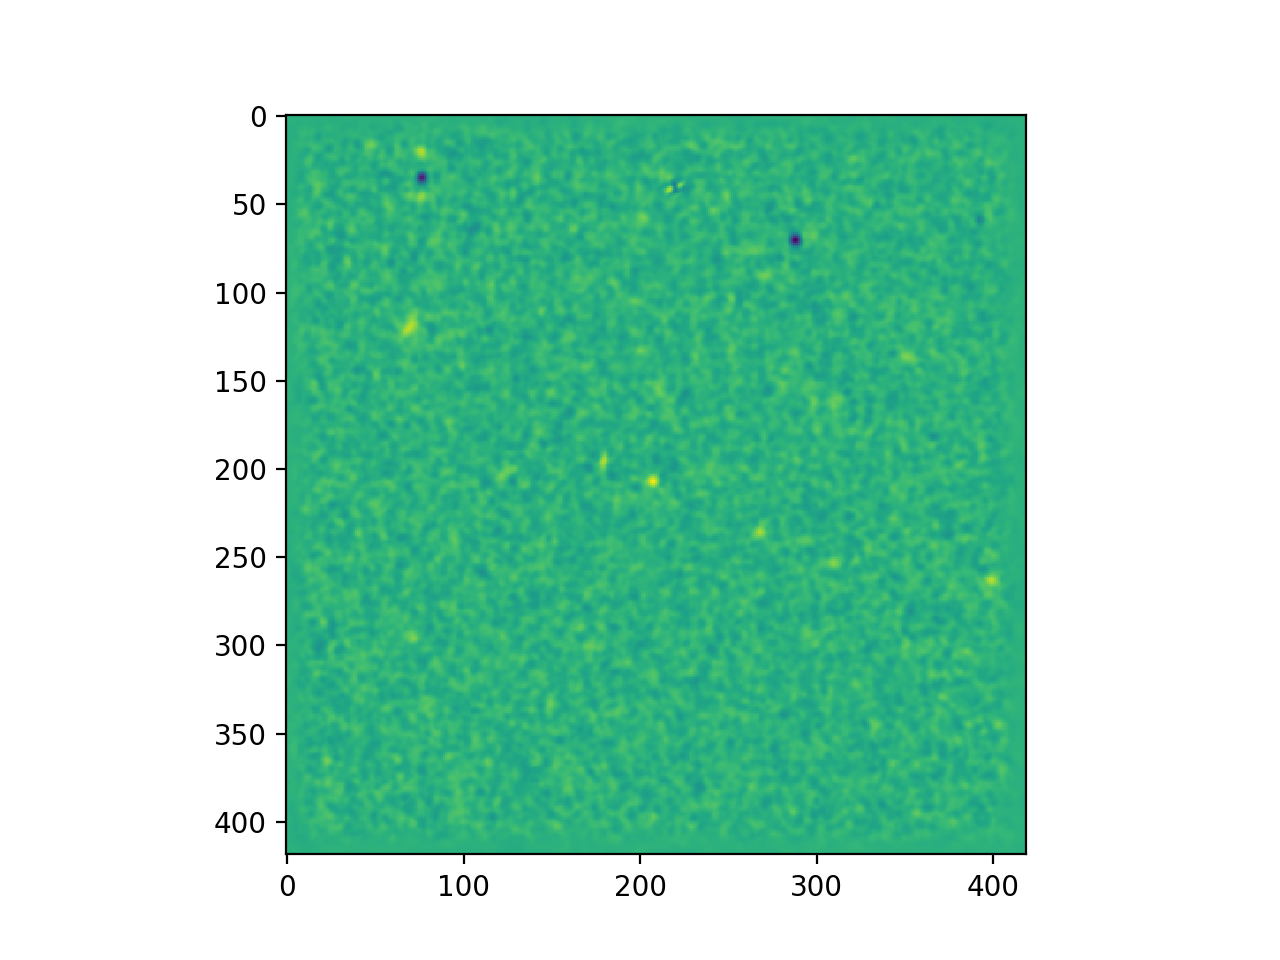

<IPython.core.display.Javascript object>


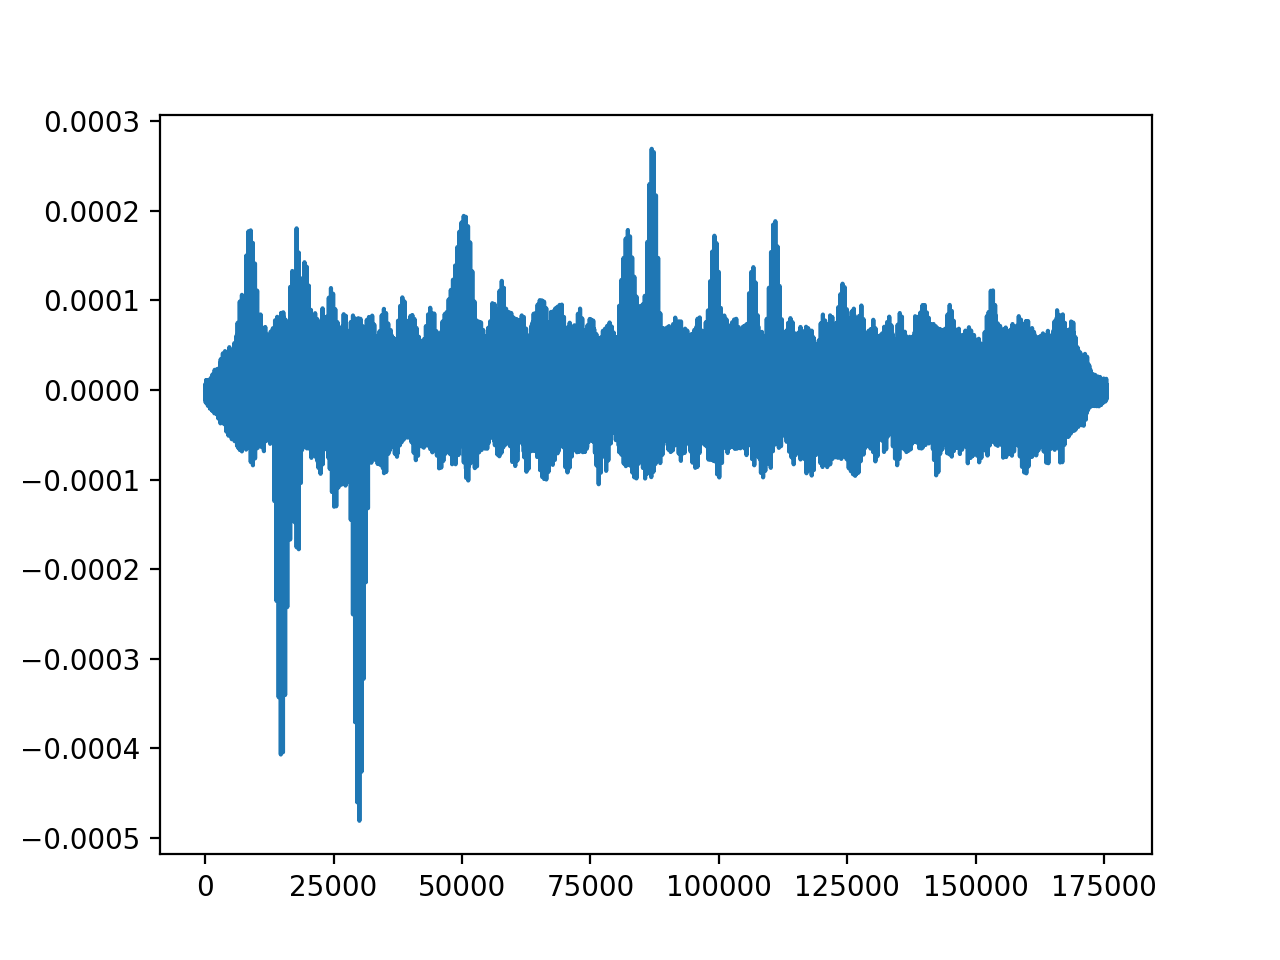

In [21]:
figure()
imshow(fdata)

figure()
plot((fdata).ravel())

In [3]:
from simulate.spatial_template import sz_pressure_profile as szp
from scipy.integrate import quad
from scipy.integrate import dblquad

In [4]:
Ycyl,norm=szp.return_Ycyl_xR500(5.,5.)
print Ycyl,norm,Ycyl/norm

586.477583518 36.6148911297 16.0174608042


In [5]:
szp.return_Ycyl_xR500?

In [8]:
szp.return_Ysph_xR500(5.,5.)
szp.return_Ysph_xR500(1.,5.)
szp.convert_Ycyl_xR500_Ysph_xR500(200.,5.,1.)

0.5489084774946067

In [9]:
theta500=5.
norm=2.*quad(szp.gnfw_3D_pressure_profile,0.,50.*theta500,args=(0.0001*theta500,theta500))[0]
print norm

36.6148911297


In [15]:
fn=lambda x: 4.*pi*szp.gnfw_3D_pressure_profile(x,0.,theta500)*x*x
sph5R500=quad(fn,0,5.*theta500)[0]
sphR500=quad(fn,0,theta500)[0]
print sph5R500,sphR500

578.314455495 321.922517454


In [12]:
fn=lambda rho,z: 2.*pi*szp.gnfw_3D_pressure_profile(z,rho,theta500)*rho
cyl5R500=2.*dblquad(fn,0,50.*theta500,lambda rho: 0., lambda rho: 5*theta500)[0]
print cyl5R500,norm,Ycyl/norm

586.477583518 36.6148911297 16.0174608042


In [35]:
print sph5R500/sphR500
print sph5R500/cyl5R500
print sphR500/cyl5R500

1.79643990134
0.986080560661
0.548908182191


In [17]:
# fn=lambda z: szp.beta_3D_pressure_profile(z,0.001*theta500,theta500)
# quad(fn,-10.*theta500,10.*theta500)[0]

In [36]:
R500=linspace(2,100,20)
Y5R500_sim=np.zeros(np.size(R500),float)
Y5R500=np.zeros(np.size(R500),float)

for idx,theta500 in enumerate(R500):
    print idx
    template=sc.gen_cluster_template(mmfset.npix,theta500,mmfset.reso,cutoff=5.)
    Y5R500_sim[idx]=np.sum(template)*mmfset.reso*mmfset.reso
    Ycyl,norm=szp.return_Ycyl_xR500(theta500,5.)
    Y5R500[idx]=Ycyl/norm

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


<IPython.core.display.Javascript object>


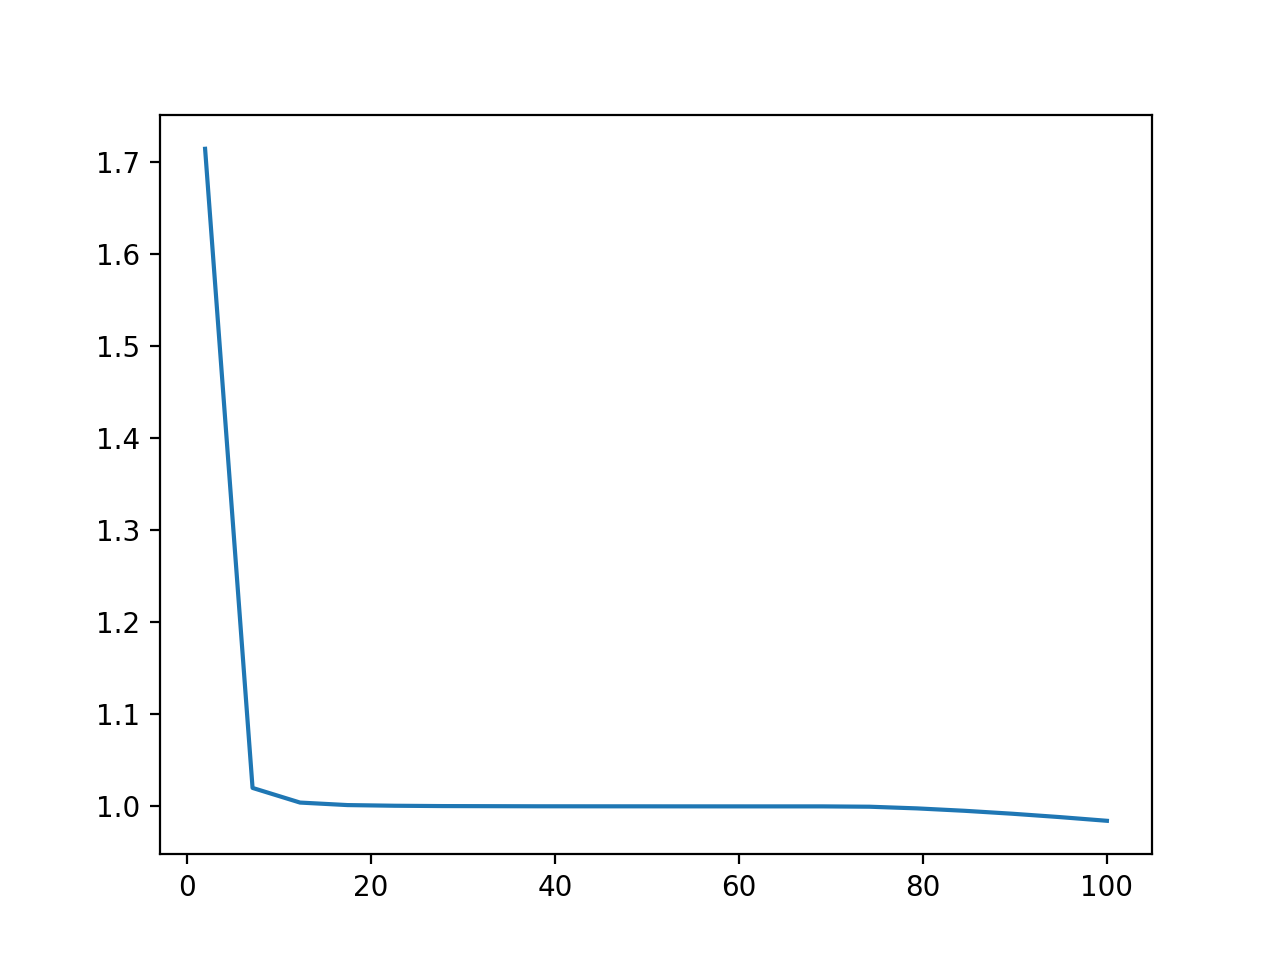

In [41]:
figure()
plot(R500,Y5R500_sim/Y5R500)

In [21]:
template=sc.gen_cluster_template(8192,theta500,0.01,cutoff=100.)

In [22]:
np.sum(template)*(0.01**2.)

16.482230429404616

In [30]:
szp.beta_2D_pressure_profile(0,theta500)

1.0000500624945423

In [36]:
0.986/1.814

0.5435501653803748